In [ ]:
"""
In this file the NN model is tuned. 
Hyperparameters include: hidden layer size; activation; beta 1 (for adam); beta 2 (for adam); 
Learning curves are constructed. 
The final model is evaluated 
"""

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns=None
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, GridSearchCV, ParameterGrid, KFold, cross_validate
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from datetime import date, datetime
import nbimporter
from Data import load_training_test_sets
import time

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Import Data

In [2]:
X_train, X_test, y_train, y_test=load_training_test_sets()

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

Import Data: Complete
Train shape:  (32561, 15) 
Test shape:  (16281, 15) 
Columns:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 

Process and Split Data: Complete 

Undersample data: Complete
Balanced train data:  (18664, 85)
Imbalanced test data:  (9769, 85) 



## Tuning 

In [3]:
def tune(X_train, y_train, param, param_range, clf=MLPClassifier(random_state=0), show_plot=True):
    #clf = SVC(random_state=0)
    
    clf_gs=GridSearchCV(estimator = clf, scoring='f1', param_grid=ParameterGrid({'{}'.format(param): [param_range]}))
 
    clf_gs.fit(X_train, y_train)
    best_param=clf_gs.best_params_[str(param)]
    best_score=round(clf_gs.best_score_, 3)
    
    print(color.BOLD+'Tuning Parameter: {}'.format(param)+color.END)
    print('Best Parameter: ', best_param)
    print('Best Score: ', best_score)
    
    if show_plot==True: 
        train_scores, test_scores=validation_curve(clf, X_train, y_train, param_name=param, param_range=param_range, scoring='f1', cv=kf)
        fig, ax = plt.subplots()
        fig.set_size_inches(10,6)
        ax.plot(range(len(param_range)), np.mean(train_scores, axis=1), '-o', label='Train')
        ax.plot(range(len(param_range)), np.mean(test_scores, axis=1), '-o', label='Val')

        ax.set_title('Validation Curve: {}'.format(param))
        ax.set_xlabel('N')
        ax.set_ylabel('F1')
        ax.set_xticks(range(len(param_range)))
        ax.set_xticklabels(param_range)
        ax.legend()
    

[(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4)]
Tuning Parameter: hidden_layer_sizes
Best Parameter:  (3, 2)
Best Score:  0.825


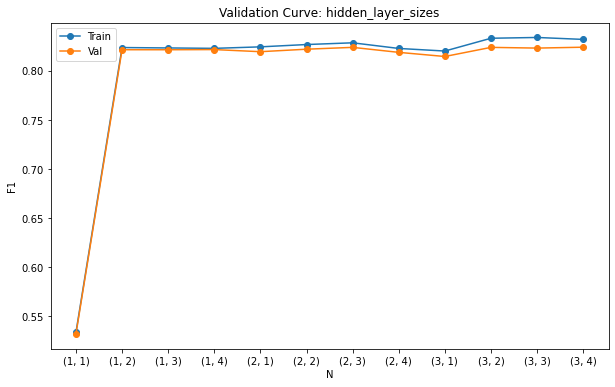

In [4]:
params=[]
for layers in [1,2,3]:
    for nodes in [1,2,3,4]:
        params.append((layers, nodes))
print(params)

param='hidden_layer_sizes'
param_range=params
clf=MLPClassifier(random_state=0, max_iter=500)
tune(X_train, y_train, param, param_range, clf)

In [8]:
best_size=(3,2)

Tuning Parameter: activation
Best Parameter:  relu
Best Score:  0.825


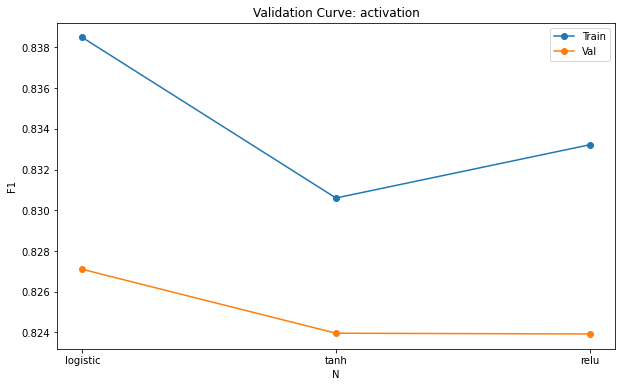

In [7]:
param='activation'
param_range=['logistic', 'tanh', 'relu']
clf=MLPClassifier(random_state=0, hidden_layer_sizes=(3,2), solver='adam', max_iter=1500)
tune(X_train, y_train, param, param_range, clf)

Tuning Parameter: beta_1
Best Parameter:  0.89
Best Score:  0.825


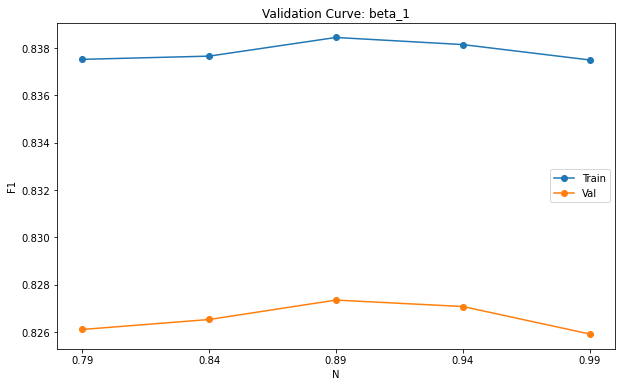

In [10]:
param='beta_1'
params=np.array(range(79, 100, 5))/100
clf=MLPClassifier(hidden_layer_sizes=(3,2), solver='adam', activation='logistic',  max_iter=1500, random_state=0)
tune(X_train, y_train, param, params, clf)

Tuning Parameter: beta_2
Best Parameter:  0.93
Best Score:  0.824


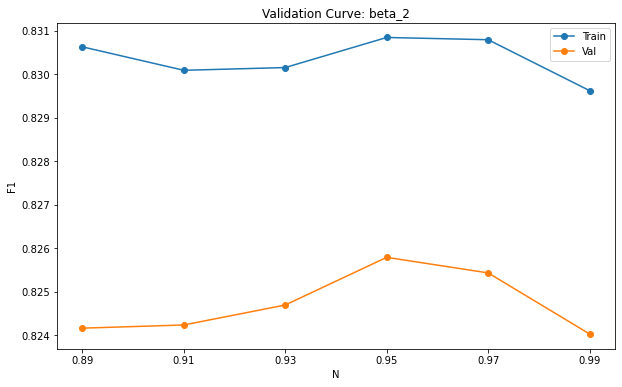

In [9]:
param='beta_2'
param_range=np.array(range(89, 100, 2))/100
clf=MLPClassifier(hidden_layer_sizes=best_size, solver='adam', activation='tanh', max_iter=1500, random_state=0)
tune(X_train, y_train, param, param_range, clf)

In [ ]:
def plot_learning_curve_nn(X_train, y_train, kf):
    clf=MLPClassifier(hidden_layer_sizes=(3,2), solver='adam', beta_1=0.99, beta_2=0.95,  max_iter=1500, activation='logistic', random_state=0)
    
    train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, scoring='f1', cv=kf, random_state=0, shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    fig, ax =plt.subplots()
    fig.set_size_inches(10,6)
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Validation")
    ax.legend()
    ax.set_xlabel('Train size')
    ax.set_ylabel('F1')
    ax.set_title('Learning Curve: F1 to Train Size')

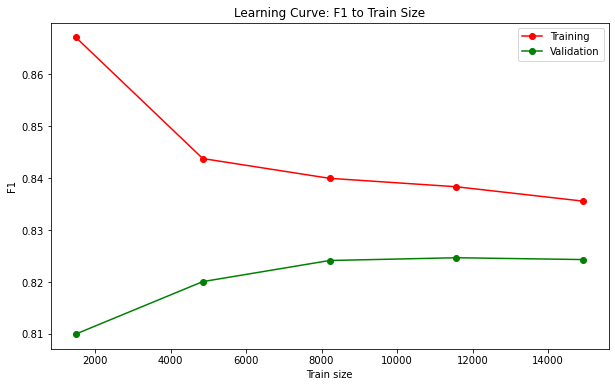

In [25]:
plot_learning_curve_nn(X_train, y_train, kf)

In [2]:
def final_model_nn(X_train, y_train, X_test, y_test):
    clf=MLPClassifier(hidden_layer_sizes=(3,2), solver='adam', beta_1=0.99, beta_2=0.95,  max_iter=1500, activation='logistic', random_state=0)
    
    start=time.time()
    final=clf
    final.fit(X_train, y_train)

    pred_train=final.predict(X_train)
    pred_test=final.predict(X_test)

    train_score=f1_score(y_train, pred_train)
    test_score=f1_score(y_test, pred_test)
    
    cm=confusion_matrix(y_test, pred_test)
    runtime=round(time.time()-start, 3)
    
    print(color.BOLD+'Train F1: '+color.END, round(train_score, 3), '\n')
    print(color.BOLD+'Test F1: '+color.END, round(test_score, 3), '\n')
    print(color.BOLD+'Run Time:' +color.END, runtime , ' seconds', '\n')
    print(color.BOLD+'Confusion Matrix: '+color.END, '\n', cm)
    
    return train_score, test_score,  runtime, cm

In [27]:
train_score, test_score,  runtime, cm= final_model_nn(X_train, y_train, X_test, y_test)

0.834
0.608
Time: 11.522  seconds
Confusion Matrix:  
 [[4667 2747]
 [ 125 2230]]


In [ ]:
# END